/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 - Loss: 210.1593
Epoch 2 - Loss: 156.5830
Epoch 3 - Loss: 137.0444

✅ Accuracy: 89.63%


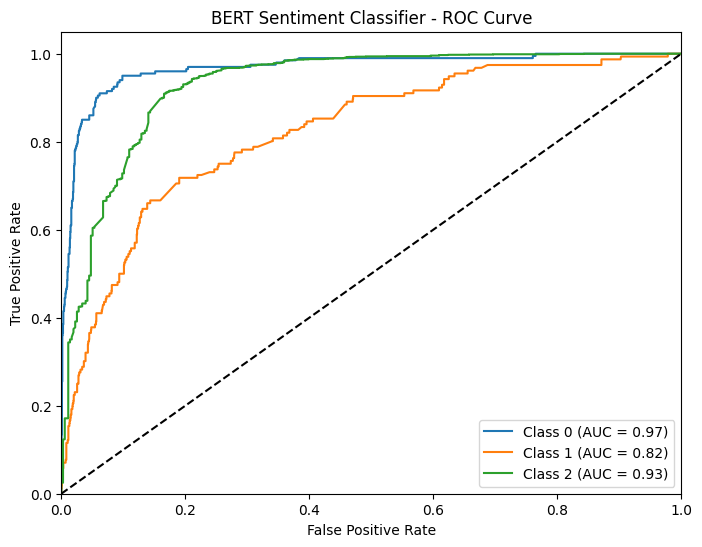

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_scheduler
from torch.optim import AdamW
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import re
import os

os.environ["WANDB_DISABLED"] = "true"

# Load & preprocess dataset
df = pd.read_csv('/content/flipkart_data (2).csv')
df = df[['review', 'rating']].dropna()
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', str(text), flags=re.MULTILINE)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    return text.lower().strip()
df['review'] = df['review'].apply(clean_text)
df['label'] = df['rating'].apply(lambda x: 2 if x >= 4 else (1 if x == 3 else 0))
df = df[['review', 'label']]

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

class FlipkartDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = FlipkartDataset(train_encodings, train_labels)
test_dataset = FlipkartDataset(test_encodings, test_labels)

class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 3)
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        out = self.dropout(pooled_output)
        return self.linear(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
total_steps = len(train_loader) * num_epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# Evaluation & ROC Curve Visualization
model.eval()
all_preds, all_labels = [], []
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask, token_type_ids)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")

# ROC Curve
n_classes = 3
all_labels_onehot = np.eye(n_classes)[all_labels]
all_probs = np.array(all_probs)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT Sentiment Classifier - ROC Curve')
plt.legend(loc="lower right")
plt.show()

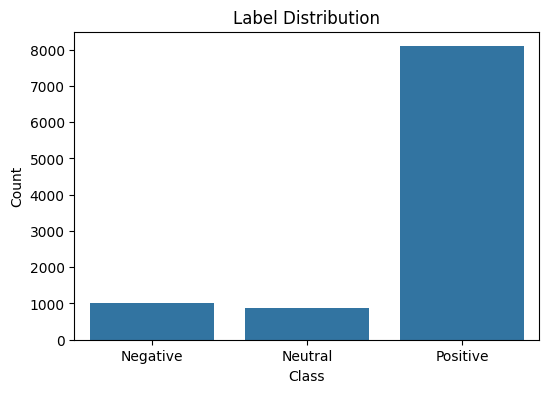

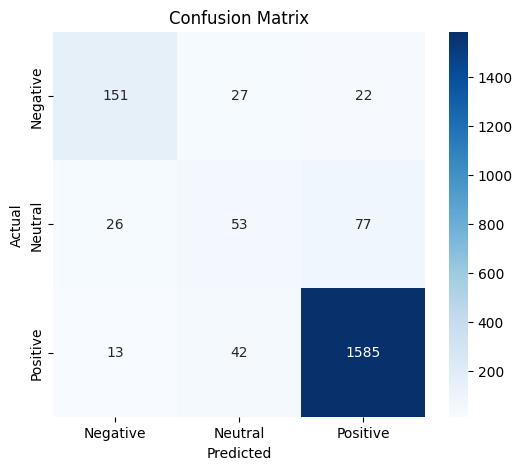

In [3]:
# ... after accuracy calculation

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Distribution chart
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()